In [17]:
import sys
sys.dont_write_bytecode = True

import time
import numpy as np  
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from IPython.display import display
from global_controller import app
import time_stitching as tst
from config import *
import span as sp
import zlib
import optimizer as opt

random.seed(1234)

timestamp_list = list()
temp_timestamp_list = list()
def LOG_TIMESTAMP(event_name):
    timestamp_list.append([event_name, time.time()])
    if len(timestamp_list) > 1:
        dur = round(timestamp_list[-1][1] - timestamp_list[-2][1], 5)
        app.logger.debug(f"{log_prefix} Finished, {event_name}, duration,{dur}")


def TEMP_LOG_TIMESTAMP(event_name):
    temp_timestamp_list.append([event_name, time.time()])
    if len(temp_timestamp_list) > 1:
        dur = round(timestamp_list[-1][1] - timestamp_list[-2][1], 5)
        app.logger.debug(f"{log_prefix} Finished, {event_name}, duration,{dur}")
        
        
def prettyprint_timestamp():
    app.logger.debug(f"{log_prefix}")
    app.logger.debug(f"{log_prefix} *")
    app.logger.debug(f"{log_prefix} ** timestamp_list(ms)")
    for i in range(1, len(timestamp_list)):
        app.logger.debug(f"{log_prefix} {timestamp_list[i][0]}", end=",")
        
def sample_df(trace_df, sampling_ratio=0.02):
    tid = list(trace_df["trace_id"].unique())
    sample_size = int(len(tid) * sampling_ratio)
    sampled_tid = random.sample(tid, sample_size)
    sampled_df = trace_df[trace_df["trace_id"].isin(sampled_tid)]
    print(sampled_df.shape)
    print(trace_df.shape)
    sampled_df.reset_index(drop=True, inplace=True)
    sampled_df.to_csv("./sampled_both_trace.txt")
    return sampled_df

def df_to_trace(df_):
    trace_dict = dict()
    # cid -> trace id -> svc_name -> span
    for index, row in df_.iterrows():
        if row["cluster_id"] not in trace_dict:
            trace_dict[row["cluster_id"]] = dict()
        if row["trace_id"] not in trace_dict[row["cluster_id"]]:
            trace_dict[row["cluster_id"]][row["trace_id"]] = dict()
        
        temp_span = sp.Span(row["svc_name"], row["cluster_id"], row["trace_id"], row["my_span_id"], row["parent_span_id"], row["st"], row["et"], row["load"], row["last_load"], row["avg_load"], row["rps"], row["call_size"], ct=row["ct"])
        # svc_name, cluster_id, trace_id, my_span_id, parent_span_id, st, et, first_load, last_load, avg_load, rps, cs):
        trace_dict[row["cluster_id"]][row["trace_id"]][row["svc_name"]] = temp_span
    return trace_dict

In [18]:
# LOG_PATH = "/home/gangmuk2/projects/SLATE/global-controller/wrk_prof_log2_west.txt"
# LOG_PATH = "/home/gangmuk2/projects/SLATE/global-controller/wrk_prof_log2_east.txt"
LOG_PATH = "/home/gangmuk2/projects/SLATE/global-controller/wrk_prof_log2_both_cluster.txt"
traces = tst.parse_trace_file_ver2(LOG_PATH)
traces, callgraph, depth_dict, trace_df = tst.stitch_time(traces)
sampled_df = sample_df(trace_df, 0.02)
display(sampled_df)
sampled_df = sampled_df[((sampled_df["svc_name"] == tst.FRONTEND_svc) & (sampled_df["ct"] > 10)) | (sampled_df["svc_name"]!=tst.FRONTEND_svc)]
traces = df_to_trace(sampled_df)

col_len: 15


[2023-10-19 20:59:17,776] INFO in time_stitching: [SLATE] time stitching starts


weird_span_id: 0
filter stats: [25, 0, 0, 29, 0, 0, 0, 0, 0]
Cluster 0
#return trace: 9688
#input trace: 9742
weird_span_id: 0
filter stats: [50, 0, 0, 58, 0, 0, 0, 0, 0]
Cluster 1
#return trace: 9688
#input trace: 9742
call_graph: {'productpage-v1': ['details-v1', 'reviews-v3'], 'ratings-v1': [], 'details-v1': [], 'reviews-v3': ['ratings-v1']}
depth_dict: {'productpage-v1': 1, 'details-v1': 2, 'reviews-v3': 2, 'ratings-v1': 3}
[SLATE] Critical Path Analysis


[2023-10-19 20:59:20,332] INFO in time_stitching: [SLATE] Cluster 0 Num Input traces: 9742
[2023-10-19 20:59:20,333] INFO in time_stitching: [SLATE] Cluster 0 Num Final valid traces: 9688
[2023-10-19 20:59:20,334] INFO in time_stitching: [SLATE] Cluster 1 Num Input traces: 9742
[2023-10-19 20:59:20,335] INFO in time_stitching: [SLATE] Cluster 1 Num Final valid traces: 9688
[2023-10-19 20:59:20,336] INFO in time_stitching: [SLATE] time stitching done: 2.556748151779175s


(1544, 18)
(77504, 18)


,svc_name,my_span_id,parent_span_id,trace_id,cluster_id,load,last_load,avg_load,rps,st,et,rt,xt,ct,child_spans,critical_child_spans,call_size,depth
0,reviews-v3,89954eba,77ebe21d,73e5de126372fd1377ebe21df2d25fe1,0,1,1,1,0,17,24,7,6,6,"[SPAN,73e5de126372fd1377ebe21df2d25fe1,ratings-v1,0,d4969ee1,89954eba,1,1,1,0,21,22,1,30]","[SPAN,73e5de126372fd1377ebe21df2d25fe1,ratings-v1,0,d4969ee1,89954eba,1,1,1,0,21,22,1,30]",20,2
1,details-v1,0aa6fc9a,77ebe21d,73e5de126372fd1377ebe21df2d25fe1,0,1,1,1,0,10,12,2,2,2,[],[],20,2
2,ratings-v1,d4969ee1,89954eba,73e5de126372fd1377ebe21df2d25fe1,0,1,1,1,0,21,22,1,1,1,[],[],30,3
3,productpage-v1,77ebe21d,,73e5de126372fd1377ebe21df2d25fe1,0,3,2,2,0,0,27,27,18,18,"[SPAN,73e5de126372fd1377ebe21df2d25fe1,reviews-v3,0,89954eba,77ebe21d,1,1,1,0,17,24,7,20, SPAN,73e5de126372fd1377ebe21df2d25fe1,details-v1,0,0aa6fc9a,77ebe21d,1,1,1,0,10,12,2,20]","[SPAN,73e5de126372fd1377ebe21df2d25fe1,reviews-v3,0,89954eba,77ebe21d,1,1,1,0,17,24,7,20, SPAN,73e5de126372fd1377ebe21df2d25fe1,details-v1,0,0aa6fc9a,77ebe21d,1,1,1,0,10,12,2,20]",10,1
4,details-v1,a66ce256,4a89409c,78806dc14139830d4a89409c75c73efb,0,1,1,1,0,8,10,2,2,2,[],[],20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,details-v1,0c531d92,5dac37c6,304ab4d7d1e80bfc5dac37c629b59ef8,1,1,1,1,0,21,66,45,45,45,[],[],20,2
1540,ratings-v1,0d2115ce,62c98386,9f9161f46fc7eb0a7fd9c11ca3c7bebb,1,1,1,1,0,189,190,1,1,1,[],[],30,3
1541,details-v1,8b35dcf9,7fd9c11c,9f9161f46fc7eb0a7fd9c11ca3c7bebb,1,1,1,1,0,75,78,3,3,3,[],[],20,2
1542,productpage-v1,7fd9c11c,,9f9161f46fc7eb0a7fd9c11ca3c7bebb,1,33,43,38,0,0,362,362,355,355,"[SPAN,9f9161f46fc7eb0a7fd9c11ca3c7bebb,details-v1,1,8b35dcf9,7fd9c11c,1,1,1,0,75,78,3,20, SPAN,9f9161f46fc7eb0a7fd9c11ca3c7bebb,reviews-v3,1,62c98386,7fd9c11c,5,4,4,0,187,191,4,20]","[SPAN,9f9161f46fc7eb0a7fd9c11ca3c7bebb,reviews-v3,1,62c98386,7fd9c11c,5,4,4,0,187,191,4,20, SPAN,9f9161f46fc7eb0a7fd9c11ca3c7bebb,details-v1,1,8b35dcf9,7fd9c11c,1,1,1,0,75,78,3,20]",10,1


In [19]:
df = pd.read_csv("./sampled_both_trace.txt")
prerecorded_trace = df_to_trace(df)
ts = time.time()
percentage_df = opt.run_optimizer(prerecorded_trace, trace_file=None, NUM_REQUESTS=[100,1000], model_parameter=None)
print("time: ", time.time() - ts)
display(percentage_df)

[2023-10-19 20:59:22,931] INFO in optimizer: [SLATE] NUMBER OF CLUSTERS: 2
[2023-10-19 20:59:22,932] INFO in optimizer: [SLATE] callgraph
[2023-10-19 20:59:22,933] INFO in optimizer: [SLATE] {'productpage-v1': ['details-v1', 'reviews-v3'], 'ratings-v1': [], 'details-v1': [], 'reviews-v3': ['ratings-v1'], 'ingress_gw': ['productpage-v1']}
[2023-10-19 20:59:22,933] INFO in optimizer: [SLATE] unique_services: ['productpage-v1', 'ratings-v1', 'details-v1', 'reviews-v3', 'ingress_gw']
[2023-10-19 20:59:22,935] INFO in optimizer: [SLATE] len(network_arc_var_name): 22

[2023-10-19 20:59:22,966] INFO in optimizer: [SLATE] productpage-v1, slope: [164.67666821], intercept: 134.04046242774567, R^2: 0.7
[2023-10-19 20:59:22,981] INFO in optimizer: [SLATE] ratings-v1, slope: [0.], intercept: 1.1965317919075145, R^2: -0.15
[2023-10-19 20:59:22,996] INFO in optimizer: [SLATE] details-v1, slope: [0.], intercept: 6.294797687861272, R^2: -0.04
[2023-10-19 20:59:23,012] INFO in optimizer: [SLATE] reviews

ratings-v1 is leaf service
details-v1 is leaf service
max_load = sum(NUM_REQUESTS):  1100
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2415150
Academic license - for non-commercial use only - registered to gangmuk2@illinois.edu


[2023-10-19 20:59:23,686] INFO in optimizer: [SLATE] model objective: 0.0


Model for pipe:
2 variables
4 constraints
Input has shape (2, 1)
Output has shape (2, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans             (2, 1)            2            2            0            0

lin_reg               (2, 1)            0            2            0            0

--------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2415150
Academic license - for non-commercial use only - registered to gangmuk2@illinois.edu
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU E5-2630L 0 @ 2.00GHz, instruction set [SSE2|AVX]
Thread count: 12 physical cores, 24 logical pro

[2023-10-19 20:59:23,781] INFO in optimizer: [SLATE] model.Status: 2
[2023-10-19 20:59:23,782] INFO in optimizer: [SLATE] NUM_REQUESTS: [100, 1000]
[2023-10-19 20:59:23,783] INFO in optimizer: [SLATE] ooooooooooooooooooooooo
[2023-10-19 20:59:23,784] INFO in optimizer: [SLATE] oooo SOLVED MODEL! oooo
[2023-10-19 20:59:23,785] INFO in optimizer: [SLATE] ooooooooooooooooooooooo
/home/gangmuk2/projects/SLATE/global-controller/optimizer.py:962: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  request_flow = pd.concat([request_flow, temp], ignore_index=True)
[2023-10-19 20:59:23,846] INFO in optimizer: [SLATE] ** timestamp_list(ms)
[2023-10-19 20:59:23,848] INFO in optimizer: [SLATE] defining compute_arc_var_name, 0.004023551940917969
[2023-10-19 2

time:  0.9330151081085205


(                                            src             dst src_cid  \
 index_col                                                                 
 (productpage-v1, 0, details-v1)  productpage-v1      details-v1       0   
 (productpage-v1, 1, details-v1)  productpage-v1      details-v1       1   
 (productpage-v1, 0, reviews-v3)  productpage-v1      reviews-v3       0   
 (productpage-v1, 1, reviews-v3)  productpage-v1      reviews-v3       1   
 (ratings-v1, 0, dst_*_*)             ratings-v1         dst_*_*       0   
 (ratings-v1, 1, dst_*_*)             ratings-v1         dst_*_*       1   
 (details-v1, 0, dst_*_*)             details-v1         dst_*_*       0   
 (details-v1, 1, dst_*_*)             details-v1         dst_*_*       1   
 (reviews-v3, 0, ratings-v1)          reviews-v3      ratings-v1       0   
 (reviews-v3, 1, ratings-v1)          reviews-v3      ratings-v1       1   
 (src_*_*, *, ingress_gw)                src_*_*      ingress_gw       *   
 (ingress_gw

ratings-v1 is leaf service
details-v1 is leaf service


[2023-10-19 20:59:27,808] INFO in 2746215315: [SLATE] Service productpage-v1, model slope: [  0.         113.12868819  52.47321399], intercept: 81.56724844084042, R^2: 0.86
[2023-10-19 20:59:27,836] INFO in 2746215315: [SLATE] Service ratings-v1, model slope: [0.], intercept: 1.1965317919075145, R^2: -0.15
[2023-10-19 20:59:27,862] INFO in 2746215315: [SLATE] Service details-v1, model slope: [0.], intercept: 6.294797687861272, R^2: -0.04
[2023-10-19 20:59:27,888] INFO in 2746215315: [SLATE] Service reviews-v3, model slope: [0.13484108], intercept: 5.005780346820809, R^2: -0.05
[2023-10-19 20:59:27,916] INFO in 2746215315: [SLATE] Service ingress_gw, model slope: [0.], intercept: 0.0, R^2: 1.0
[2023-10-19 20:59:27,943] INFO in 2746215315: [SLATE] Service productpage-v1, model slope: [  0.         113.12868819  52.47321399], intercept: 81.56724844084042, R^2: 0.86
[2023-10-19 20:59:27,965] INFO in 2746215315: [SLATE] Service ratings-v1, model slope: [0.], intercept: 1.1965317919075145, R

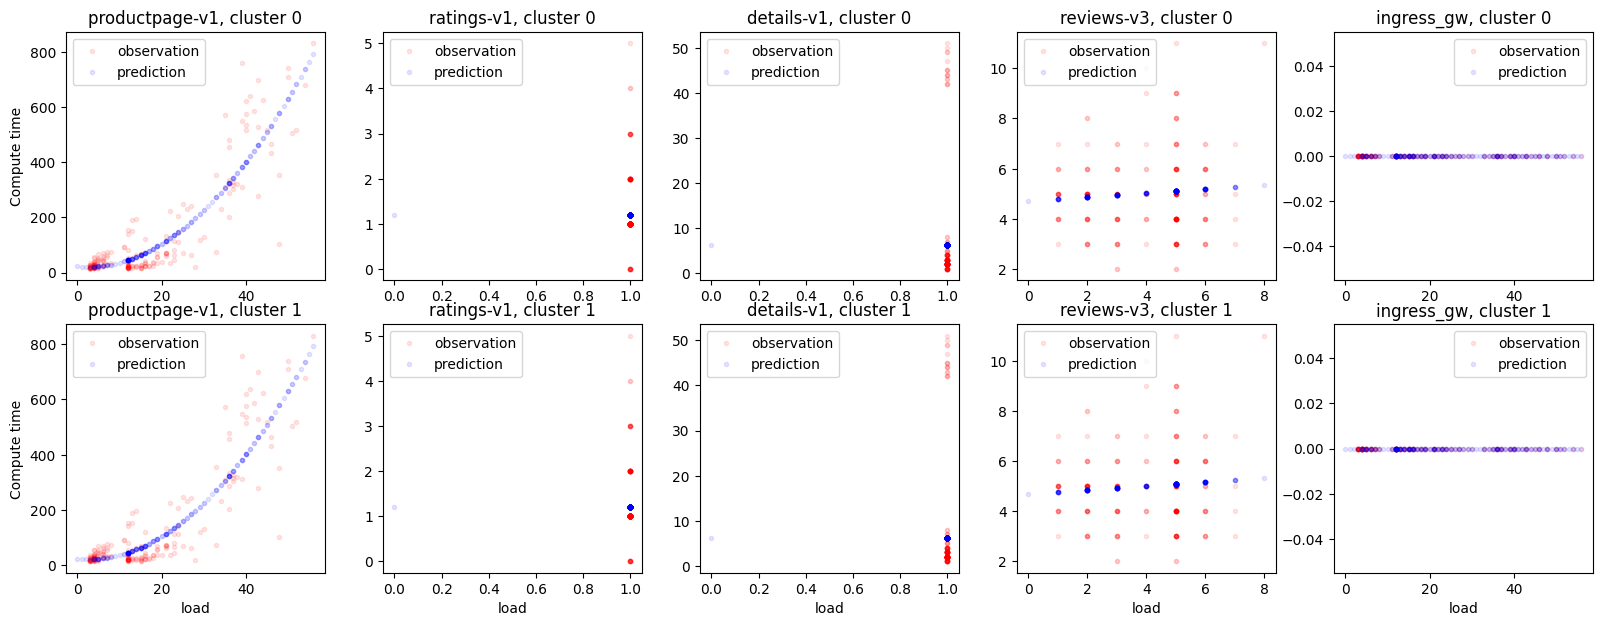

In [20]:
NUM_CLUSTER = len(traces)
    
if ENTRANCE == INGRESS_GW_NAME:
    callgraph[INGRESS_GW_NAME] = list()
    for parent_svc, children in callgraph.items():
        if parent_svc == tst.FRONTEND_svc:
            callgraph[INGRESS_GW_NAME].append(parent_svc)
    for parent_svc, child_svc_list in callgraph.items():
        app.logger.debug(f"{log_prefix} {parent_svc}: {child_svc_list}")
app.logger.debug(f"{log_prefix} callgraph")
app.logger.debug(f"{log_prefix} {callgraph}")
unique_services = list(callgraph.keys())
app.logger.debug(f"{log_prefix} unique_services: {unique_services}")


## In[33]:

def span_to_compute_arc_var_name(svc_name, cid):
    return (svc_name+DELIMITER+str(cid)+DELIMITER+"start", svc_name+DELIMITER+str(cid)+DELIMITER+"end") # return type: tuple

def spans_to_network_arc_var_name(parent_name, src_cid, child_name, dst_cid):
    if parent_name == "src_*_*":
        src_postfix = "*"
    else:
        src_postfix = "end"
    if child_name == "dst_*_*":
        dst_postfix = "*"
    else:
        dst_postfix = "start"
    src_name = parent_name+DELIMITER+str(src_cid)+DELIMITER+src_postfix
    dst_name = child_name+DELIMITER+str(dst_cid)+DELIMITER+dst_postfix
    return (src_name, dst_name)


## In[34]:

svc_name_list = list()
compute_arc_var_name = dict()
per_service_compute_arc = dict()
for svc_name in unique_services:
    for cid in range(NUM_CLUSTER):
        var_name = span_to_compute_arc_var_name(svc_name, cid)
        compute_arc_var_name[var_name] = list()
        if svc_name not in per_service_compute_arc:
            per_service_compute_arc[svc_name] = list()
        per_service_compute_arc[svc_name].append(var_name)
    
LOG_TIMESTAMP("defining compute_arc_var_name")
if DISPLAY:
    display(compute_arc_var_name)


# In[35]:


## Define names of the variables for network arc in gurobi
source_name = "src_*_*"
destination_name = "dst_*_*"
source_node = source_name+DELIMITER+"*"+DELIMITER+"*"
destination_node = destination_name+DELIMITER+"*"+DELIMITER+"*"

'''
network_arc_var_name
- key: tuple(src_node_name, dst_node_name)
- value: request_size_in_bytes
'''
network_arc_var_name = dict()
for parent_svc, children in callgraph.items():
    if len(children) == 0: # leaf service
        # leaf service to dst
        print(parent_svc + " is leaf service")
        for src_cid in range(NUM_CLUSTER):
            tuple_var_name = spans_to_network_arc_var_name(parent_svc, src_cid, destination_name, "*")
            if tuple_var_name not in network_arc_var_name:
                network_arc_var_name[tuple_var_name] = 0 # arbitrary call size
    for child_svc in children:
        if parent_svc == ENTRANCE:
            for src_cid in range(NUM_CLUSTER):
                # src to ingress gateway
                tuple_var_name = spans_to_network_arc_var_name(source_name, "*", parent_svc, src_cid)
                if tuple_var_name not in network_arc_var_name:
                    network_arc_var_name[tuple_var_name] = 0 # arbitrary call size
                for dst_cid in range(NUM_CLUSTER):
                    tuple_var_name = spans_to_network_arc_var_name(parent_svc, src_cid, child_svc, dst_cid)
                    if tuple_var_name not in network_arc_var_name:
                        # ingress gateway to frontend service
                        network_arc_var_name[tuple_var_name] = 1 # arbitrary call size
        else:
            # service to service
            for src_cid in range(NUM_CLUSTER):
                for dst_cid in range(NUM_CLUSTER):
                    tuple_var_name = spans_to_network_arc_var_name(parent_svc, src_cid, child_svc, dst_cid)
                    if tuple_var_name not in network_arc_var_name:
                        network_arc_var_name[tuple_var_name] = depth_dict[parent_svc]*10 # arbitrary call size
app.logger.debug(f"{log_prefix} len(network_arc_var_name): {len(network_arc_var_name)}\n")
for tuple_var_name, _ in network_arc_var_name.items():
    app.logger.debug(f"{log_prefix} {tuple_var_name}")

if ENTRANCE == tst.FRONTEND_svc:
    if tst.REVIEW_V1_svc in unique_services:
        assert len(network_arc_var_name) == 14 # bookinfo, without ingress gw, two cluster set up
    else:
        assert len(network_arc_var_name) == 18 # bookinfo, without ingress gw, two cluster set up
elif ENTRANCE == INGRESS_GW_NAME:
    if tst.REVIEW_V1_svc in unique_services:
        assert len(network_arc_var_name) == 18 # bookinfo, with ingress gw, two cluster set up
    elif PRODUCTPAGE_ONLY:
        assert len(network_arc_var_name) == 8
    else:
        assert len(network_arc_var_name) == 22 # bookinfo, with ingress gw, two cluster set up
else:
    assert False


def check_network_arc_var_name(net_arc_var_n):
    for (src, dst), _ in net_arc_var_n.items():
        src_node = src.split(DELIMITER)[0]
        dst_node = dst.split(DELIMITER)[0]
        src_postfix = src.split(DELIMITER)[-1]
        dst_postfix = dst.split(DELIMITER)[-1]
        if src_node == source_name:
            assert dst_postfix == "start" 
        elif dst_node == destination_name:
            assert src_postfix == "end" 
        else:
            assert src_postfix == "end" 
            assert dst_postfix == "start" 
        
check_network_arc_var_name(network_arc_var_name)
if DISPLAY:
    display(network_arc_var_name)
    
## In[37]:

load = list()
comp_t = list()
service_name_ = list()
index_ = list()
cid_list = list()
for cid in traces:
    for tid, spans in traces[cid].items():
        for svc_name, span in spans.items():
            load.append(span.load)
            comp_t.append(span.ct)
            index_.append(span_to_compute_arc_var_name(span.svc_name, span.cluster_id))
            service_name_.append(span.svc_name)
            cid_list.append(span.cluster_id)
            if ENTRANCE == INGRESS_GW_NAME:
                if span.svc_name == tst.FRONTEND_svc:
                    load.append(span.load)
                    # load.append(span.last_load)
                    # load.append(span.avg_load)
                    comp_t.append(0)
                    index_.append(span_to_compute_arc_var_name(ENTRANCE, span.cluster_id))
                    service_name_.append(ENTRANCE)
                    cid_list.append(span.cluster_id)
compute_time_observation = pd.DataFrame(
    data={
        "service_name": service_name_,
        "load": load, 
        "compute_time": comp_t,
        "cluster_id": cid_list,
    },
    index=index_
)
if DISPLAY:
    print("compute_time_observation")
    # with pd.option_context('display.max_rows', None):
    # print(compute_time_observation[(compute_time_observation["service_name"]=="details-v1") & (compute_time_observation["cluster_id"]==0)])
    # print(compute_time_observation[(compute_time_observation["service_name"]=="details-v1") & (compute_time_observation["cluster_id"]==1)])
    
    # with pd.option_context('display.max_rows', None):
    display(compute_time_observation)


# In[38]:


## Per-service load-to-compute time modeling.
idx = 0
num_subplot_row = 2
num_subplot_col = 5
fig, (plot_list) = plt.subplots(num_subplot_row, num_subplot_col, figsize=(16,6))
fig.tight_layout()

max_compute_time = dict()
# max_load = dict()
# max_compute_time = dict()
regressor_dict = dict()
for cid in range(NUM_CLUSTER):
    cid_df =  compute_time_observation[compute_time_observation["cluster_id"]==cid]
    for svc_name in unique_services:
        temp_df = cid_df[cid_df["service_name"] == svc_name]
        frontend_temp_df = cid_df[cid_df["service_name"] == tst.FRONTEND_svc]
        if ALL_PRODUCTPAGE:
            X = frontend_temp_df[["load"]]
            y = frontend_temp_df["compute_time"]
            X.index = temp_df.index
            y.index = temp_df.index
        else:
            X = temp_df[["load"]]
            y = temp_df["compute_time"]
        # display(X)
        temp_x = X.copy()
        # for i in range(len(temp_x)):
        # print("max(temp_x)")
        # print(max(temp_x["load"]))
        for i in range(max(temp_x["load"])):
            temp_x.iloc[i, 0] = i
        # print("len(temp_x)")
        # print(len(temp_x))
        # print("temp_x")
        # print(temp_x)
        #############################################
        # if ENTRANCE == INGRESS_GW_NAME and svc_name == ENTRANCE:
        #     max_compute_time[svc_name] = 0
        # else:
        #     max_compute_time[svc_name] = 1000000
        #############################################
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.9, random_state=1
        )
        feat_transform = make_column_transformer(
            (StandardScaler(), ["load"]),
            # ("passthrough", ["load"]),
            verbose_feature_names_out=False,
            remainder='drop'
        )
        if svc_name == tst.FRONTEND_svc:
            REGRESSOR_DEGREE = 2
        else:
            REGRESSOR_DEGREE = 1
        if REGRESSOR_DEGREE == 1:
            regressor_dict[svc_name] = make_pipeline(feat_transform, LinearRegression())
            regressor_dict[svc_name].fit(X_train, y_train)
        elif REGRESSOR_DEGREE > 1:
            poly = PolynomialFeatures(degree=REGRESSOR_DEGREE, include_bias=True)
            regressor_dict[svc_name] = make_pipeline(feat_transform, poly, LinearRegression())
            regressor_dict[svc_name].fit(X_train, y_train)
        ## Run prediction and compare it with the ground truth to see how accurate the trained model is
        y_pred = regressor_dict[svc_name].predict(X_test)
        c_ = regressor_dict[svc_name]["linearregression"].coef_
        in_ = regressor_dict[svc_name]["linearregression"].intercept_
        r2 =  np.round(r2_score(y_test, y_pred),2)
        app.logger.info(f"{log_prefix} Service {svc_name}, model slope: {c_}, intercept: {in_}, R^2: {r2}")
        row_idx = int(idx/num_subplot_col)
        col_idx = idx%num_subplot_col
        plot_list[row_idx][col_idx].plot(X, y, 'r.', label="observation", alpha=0.1)
        plot_list[row_idx][col_idx].plot(temp_x, regressor_dict[svc_name].predict(temp_x), 'b.', label="prediction", alpha=0.1)
        plot_list[row_idx][col_idx].legend()
        plot_list[row_idx][col_idx].set_title(svc_name + ", cluster " + str(cid))
        if row_idx == num_subplot_row-1:
            plot_list[row_idx][col_idx].set_xlabel("load")
        if col_idx == 0:
            plot_list[row_idx][col_idx].set_ylabel("Compute time")
        if svc_name != tst.FRONTEND_svc and c_ < 0:
            print("type(c_): ", type(c_))
            new_c = np.array([0.])
            regressor_dict[svc_name]["linearregression"].coef_ = new_c
            app.logger.debug(f"{log_prefix} Service {svc_name}, changed slope {c_} --> {new_c}, intercept: {in_}")
        idx += 1
    